In [1]:
import torch
import numpy
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data

In [3]:
data = datasets.load_boston()
X = torch.tensor(data['data'], dtype=torch.float32)
y = torch.tensor(data['target'], dtype=torch.float32)
N, F = X.shape

In [4]:
N

506

In [5]:
F

13

In [6]:
def squared_loss(y, yhat):
    return (y - yhat).T @ (y - yhat)

def plot_losses(losses):
    plt.plot(losses)
    plt.title(f'Min loss: {min(losses)}')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

# Basic Ops

In [7]:
a = torch.ones(3)
a

tensor([1., 1., 1.])

In [8]:
b = torch.zeros(3)
b

tensor([0., 0., 0.])

In [9]:
c = torch.randn(2, 3)
c

tensor([[-0.7163, -0.0706,  0.2498],
        [-0.3631,  1.1142, -0.6671]])

In [10]:
e = torch.randn(3, 2)
e

tensor([[-1.5099, -2.2312],
        [ 1.1799, -1.1706],
        [ 0.1739,  1.1424]])

In [11]:
a + a

tensor([2., 2., 2.])

In [12]:
c + a

tensor([[0.2837, 0.9294, 1.2498],
        [0.6369, 2.1142, 0.3329]])

In [13]:
(2 * a) * (b + 1)

tensor([2., 2., 2.])

In [14]:
c @ a

tensor([-0.5371,  0.0841])

# Linear Model - Closed Form Solution

In [15]:
w = torch.ones(F)
squared_loss(y, X @ w).item()

415916960.0

In [16]:
w = torch.inverse(X.T @ X) @ X.T @ y
squared_loss(y, X @ w).item()

12228.0478515625

# Autograd

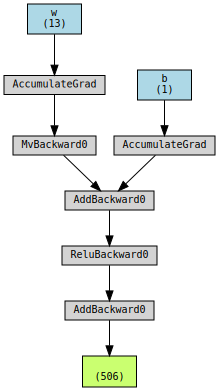

In [17]:
from torchviz import make_dot

class Test(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.w = torch.nn.Parameter(torch.randn(13))
        self.b = torch.nn.Parameter(torch.randn(1))
        
    def forward(self, x):
        x = x @ self.w + self.b
        x = torch.relu(x) + 5
        return x

t = Test()
yhat = t(X)
make_dot(yhat, params=dict(t.named_parameters()))

# Linear Model - Gradient descent

In [18]:
torch.manual_seed(42)
w = torch.randn(F)
jacobian = 2 * X.T @ X @ w - 2 * y.T @ X
jacobian

tensor([2.3221e+06, 5.3542e+06, 6.6860e+06, 4.0250e+04, 3.1928e+05, 3.5145e+06,
        4.0768e+07, 2.0103e+06, 5.8222e+06, 2.3985e+08, 1.0464e+07, 2.0328e+08,
        7.5088e+06])

In [19]:
torch.manual_seed(42)
w = torch.randn(F, requires_grad=True)
loss = (y - (X @ w)).T @ (y - (X @ w))
loss.backward()
w.grad

tensor([2.3221e+06, 5.3542e+06, 6.6860e+06, 4.0250e+04, 3.1928e+05, 3.5145e+06,
        4.0768e+07, 2.0103e+06, 5.8222e+06, 2.3985e+08, 1.0464e+07, 2.0328e+08,
        7.5088e+06])

In [20]:
torch.manual_seed(42)
w = torch.randn(F, requires_grad=True)
loss = squared_loss(y, X @ w)
loss.backward()
w.grad

tensor([2.3221e+06, 5.3542e+06, 6.6860e+06, 4.0250e+04, 3.1928e+05, 3.5145e+06,
        4.0768e+07, 2.0103e+06, 5.8222e+06, 2.3985e+08, 1.0464e+07, 2.0328e+08,
        7.5088e+06])

In [21]:
torch.manual_seed(42)
w = torch.randn(F)

losses = []
for i in range(100_000):
    pred = X @ w
    loss = squared_loss(y, pred)
    jacobian = 2 * X.T @ X @ w - 2 * y.T @ X
    w -= 5e-9 * jacobian
    losses.append(loss.item())

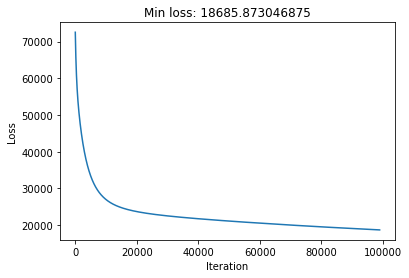

In [22]:
plot_losses(losses[1_000:])

In [23]:
torch.manual_seed(42)
w = torch.randn(F, requires_grad=True)

losses = []
for i in range(100_000):
    pred = X @ w
    loss = squared_loss(y, pred)
    loss.backward()
    with torch.no_grad():
        w -= 5e-9 * w.grad
        w.grad = None
    losses.append(loss.item())

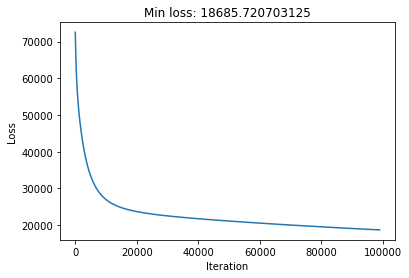

In [24]:
plot_losses(losses[1_000:])

# Linear Model - Newton's method

In [25]:
torch.manual_seed(42)
w = torch.randn(F)
hessian = 2 * X.T @ X
hessian[:2]

tensor([[8.7941e+04, 9.3741e+02, 6.4958e+04, 1.2962e+02, 2.4522e+03, 2.1644e+04,
         3.3703e+05, 6.9325e+03, 8.2237e+04, 2.3461e+06, 7.2943e+04, 9.9891e+05,
         7.4537e+04],
        [9.3741e+02, 6.8006e+05, 4.1806e+04, 5.4000e+02, 4.9689e+03, 7.7437e+04,
         4.1097e+05, 7.6599e+04, 4.5836e+04, 3.4459e+06, 1.9226e+05, 4.4792e+06,
         7.6039e+04]])

In [26]:
torch.manual_seed(42)
w = torch.randn(F, requires_grad=True)
hessian = torch.autograd.functional.hessian(lambda w: squared_loss(y, X @ w), w)
hessian[:2]

tensor([[8.7941e+04, 9.3741e+02, 6.4958e+04, 1.2962e+02, 2.4522e+03, 2.1644e+04,
         3.3703e+05, 6.9325e+03, 8.2237e+04, 2.3461e+06, 7.2943e+04, 9.9891e+05,
         7.4537e+04],
        [9.3741e+02, 6.8006e+05, 4.1806e+04, 5.4000e+02, 4.9689e+03, 7.7437e+04,
         4.1097e+05, 7.6599e+04, 4.5836e+04, 3.4459e+06, 1.9226e+05, 4.4792e+06,
         7.6039e+04]])

In [27]:
torch.manual_seed(42)
w = torch.randn(F)

losses = []
for i in range(5):
    pred = X @ w
    loss = squared_loss(y, pred)
    jacobian = 2 * X.T @ X @ w - 2 * y.T @ X
    hessian = 2 * X.T @ X
    w -= torch.inverse(hessian) @ jacobian
    losses.append(loss.item())

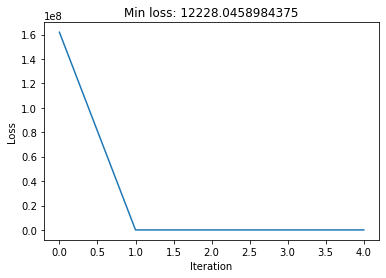

In [28]:
plot_losses(losses)

In [29]:
torch.manual_seed(42)
w = torch.randn(F, requires_grad=True)

losses = []
for i in range(5):
    pred = X @ w
    loss = squared_loss(y, pred)
    loss.backward()
    hessian = torch.autograd.functional.hessian(lambda w: squared_loss(y, X @ w), w)
    jacobian = w.grad
    with torch.no_grad():
        w -= torch.inverse(hessian) @ jacobian
        w.grad = None
    losses.append(loss.item())

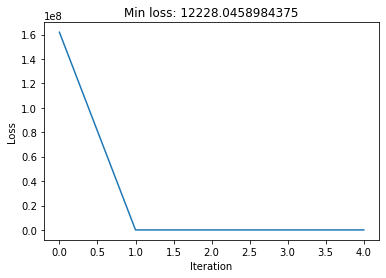

In [30]:
plot_losses(losses)

# Numpy vs PyTorch Style

In [31]:
torch.manual_seed(42)

w = torch.randn(F, requires_grad=True)
optimizer = torch.optim.SGD([w], lr=5e-9)

losses = []
for i in range(100_000):
    pred = X @ w
    loss = squared_loss(y, pred)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())

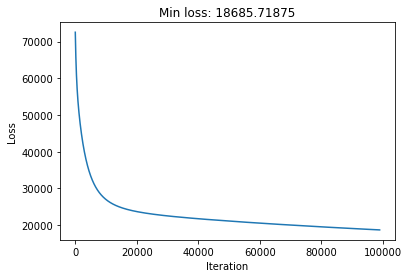

In [32]:
plot_losses(losses[1_000:])

In [33]:
torch.manual_seed(42)

class LinearModel(torch.nn.Module):
    
    def __init__(self, F):
        super().__init__()
        self.w = torch.nn.Parameter(torch.randn(F))
        
    def forward(self, X):
        return X @ self.w

model = LinearModel(F)
optimizer = torch.optim.SGD(model.parameters(), lr=5e-9)

losses = []
for i in range(100_000):
    pred = model(X)
    loss = squared_loss(y, pred)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())

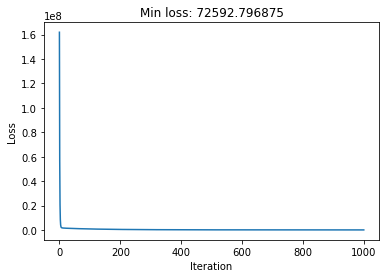

In [34]:
plot_losses(losses[:1000]) # Unsure why doesn't match?

# Neural Network

In [35]:
torch.manual_seed(42)

class NeuralNetwork(torch.nn.Module):
    
    def __init__(self, F):
        super().__init__()
        self.lin1 = torch.nn.Linear(F, 128, bias=False)
        self.lin2 = torch.nn.Linear(128, 1, bias=False)
        
    def forward(self, X):
        X = self.lin1(X)
        X = torch.relu(X)
        X = self.lin2(X)
        X = torch.sigmoid(X)
        X = X * 45 + 5
        return X.flatten()

model = NeuralNetwork(F)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

losses = []
for i in range(100_000):
    pred = model(X)
    loss = squared_loss(y, pred)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())

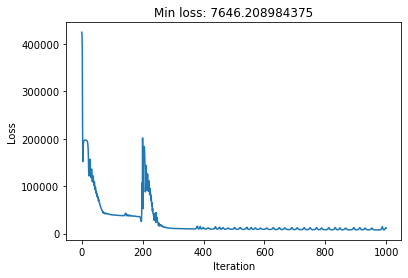

In [36]:
plot_losses(losses[:1000])

# Neural Network - Deployment

In [37]:
trace = torch.jit.trace(model, X)

In [38]:
print(trace.code)

def forward(self,
    X: Tensor) -> Tensor:
  lin2 = self.lin2
  lin1 = self.lin1
  input = torch.relu((lin1).forward(X, ))
  X0 = torch.sigmoid((lin2).forward(input, ))
  X1 = torch.add(torch.mul(X0, CONSTANTS.c0), CONSTANTS.c1)
  return torch.flatten(X1)



In [39]:
print(trace.graph)

graph(%self.1 : __torch__.NeuralNetwork,
      %X.1 : Float(506, 13, strides=[13, 1], requires_grad=0, device=cpu)):
  %lin2 : __torch__.torch.nn.modules.linear.___torch_mangle_0.Linear = prim::GetAttr[name="lin2"](%self.1)
  %lin1 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="lin1"](%self.1)
  %34 : Tensor = prim::CallMethod[name="forward"](%lin1, %X.1)
  %input : Float(506, 128, strides=[128, 1], requires_grad=1, device=cpu) = aten::relu(%34) # /tmp/ipykernel_107193/1512604603.py:12:0
  %35 : Tensor = prim::CallMethod[name="forward"](%lin2, %input)
  %X.7 : Float(506, 1, strides=[1, 1], requires_grad=1, device=cpu) = aten::sigmoid(%35) # /tmp/ipykernel_107193/1512604603.py:14:0
  %18 : Long(requires_grad=0, device=cpu) = prim::Constant[value={45}]() # /tmp/ipykernel_107193/1512604603.py:15:0
  %19 : Float(506, 1, strides=[1, 1], requires_grad=1, device=cpu) = aten::mul(%X.7, %18) # /tmp/ipykernel_107193/1512604603.py:15:0
  %20 : Long(requires_grad=0, device=cpu) =

In [40]:
trace.save('/tmp/model.pt')

# Functional Form

In [41]:
torch.manual_seed(42)

class FunctionalModel(torch.nn.Module):
    
    def __init__(self, F):
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.ones(F))
        self.w2 = torch.nn.Parameter(torch.ones(F))
        
    def forward(self, X):
        if X.sum() < 1:
            X = torch.exp(X @ self.w1 - 1)
            X = torch.sigmoid(X)
        else:
            X = torch.log(X @ self.w2 + 1)
            X = torch.tanh(X)
        return X.flatten()

model = FunctionalModel(F)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

losses = []
for i in range(100_000):
    pred = model(X)
    loss = squared_loss(y, pred)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss.item())

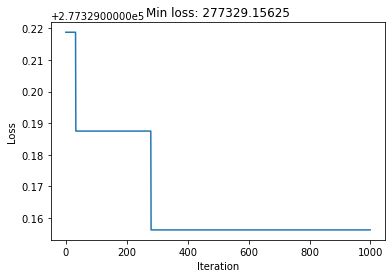

In [42]:
plot_losses(losses[:1000])

# Functional Form - Deployment

In [43]:
trace = torch.jit.trace(model, X)

In [44]:
print(trace.code)

def forward(self,
    X: Tensor) -> Tensor:
  w2 = self.w2
  _0 = torch.add(torch.matmul(X, w2), CONSTANTS.c0)
  X0 = torch.log(_0)
  X1 = torch.tanh(X0)
  return torch.flatten(X1)



In [45]:
script = torch.jit.script(model, X)

In [46]:
print(script.code)

def forward(self,
    X: Tensor) -> Tensor:
  if bool(torch.lt(torch.sum(X), 1)):
    w1 = self.w1
    X1 = torch.exp(torch.sub(torch.matmul(X, w1), 1))
    X0 = torch.sigmoid(X1)
  else:
    w2 = self.w2
    X2 = torch.log(torch.add(torch.matmul(X, w2), 1))
    X0 = torch.tanh(X2)
  return torch.flatten(X0)



# Visualization

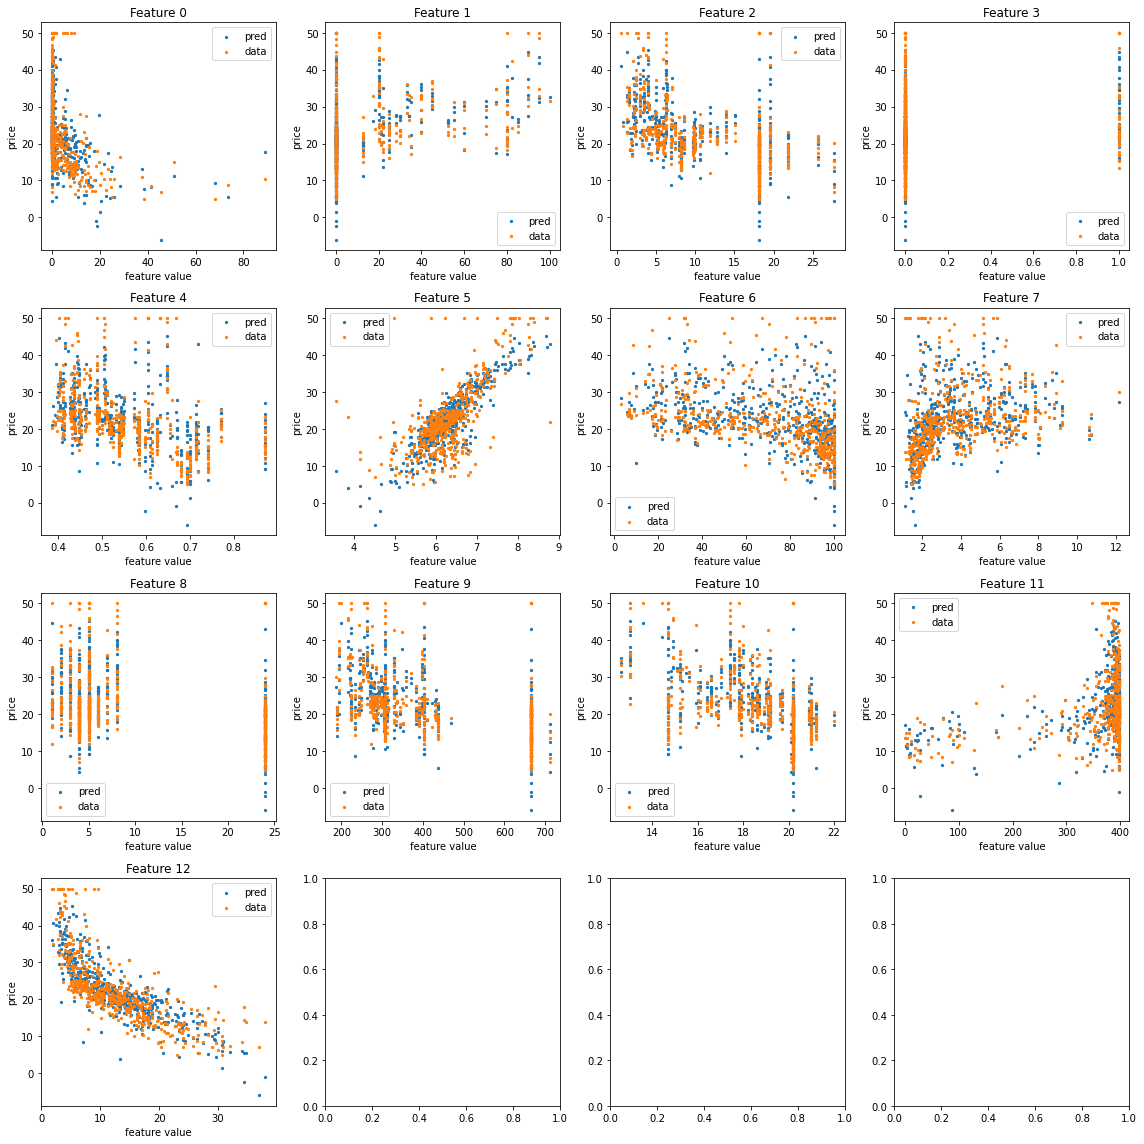

In [47]:
w = torch.inverse(X.T @ X) @ X.T @ y
yhat = (X @ w).detach().numpy()
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for i, x in enumerate(X.T):
    ax = axes[i // 4][i % 4]
    xs, idx = torch.sort(x)
    ax.scatter(xs, yhat[idx], label='pred', s=5, c='C0')
    ax.scatter(x, y, label='data', s=5, c='C1')
    ax.set_title(f'Feature {i}')
    ax.set_ylabel('price')
    ax.set_xlabel('feature value')
    ax.legend()
plt.tight_layout()